---
title: "Plot amount of variance by spectral depth"

author: "Benjamin Doran"

date: today

---

## Setup

In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI
using Muon, CSV, DataFrames
using StatsPlots, StatsBase
theme(:default, grid=false, tickdir=:out, label="")
using Random: seed!
# using FreqTables

getlims(x) = x |> extrema |> x->abs.(x) |> maximum |> x->(-x,x)

function getlims(x, y) 
    lims = extrema(vcat(x, y))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
end

getlims (generic function with 2 methods)

In [2]:
ddir = datadir("exp_pro", "BB669")
pdir = plotsdir("explainedvar") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21485
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [3]:
keptspecies = string.(keys(sort(filter(x-> last(x) > 19, countmap(biobank.obs.species)), byvalue=true, rev=true)))
filter!(!=("unclassified"), keptspecies)
full_train_mask = in.(biobank.obs.species, Ref(keptspecies));
full_test_mask = .!(full_train_mask);

In [4]:
countmap(filter(:species => x->contains(x, "rectale"), biobank.obs).donor)

Dict{String, Int64} with 5 entries:
  "MSK.22" => 5
  "MSK.17" => 8
  "MSK.9"  => 2
  "MSK.13" => 3
  "MSK.16" => 2

In [5]:
mtx = biobank["UPorder_oggs"].X[:,:];

In [6]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.03022666734934216

In [7]:
bbmtx = float.(biobank["oggs"].X[:, :])
bbmtx_trn = bbmtx[full_train_mask, :]
bbmtx_tst = bbmtx[full_test_mask, :]
# filter out oggs that are constant
ogg_mask = vec(mapslices(c->std(c) > 0, bbmtx_trn, dims=1))
bbmtx_trn = bbmtx_trn[:, ogg_mask]
bbmtx_tst = bbmtx_tst[:, ogg_mask]
bbusv_internal = svd(bbmtx_trn)
BBUinternal_tst = projectinLSV(bbmtx_tst, bbusv_internal)
BBpcs_trn = bbusv_internal.U * diagm(bbusv_internal.S)
BBpcs_tst = BBUinternal_tst * diagm(bbusv_internal.S);

In [8]:
size(bbmtx)

(669, 11248)

In [9]:
size(bbmtx_trn)

(356, 5449)

In [10]:
size(bbmtx_tst)

(313, 5449)

## Subclade variance

In [12]:
csbusv = svd(bbmtx);

In [13]:
norm(bbmtx)

3928.859630987088

In [14]:
csbnorm = norm(bbmtx);

In [15]:
explainedvariance(bbusv.S)

7047-element Vector{Float64}:
 0.5155354386274686
 0.07595279467013291
 0.05337036589579239
 0.043348784138771385
 0.024394619819993826
 0.019041075530514807
 0.014042211514131885
 0.013544378659218934
 0.010975319499256984
 0.010782501434040992
 ⋮
 2.951695770361969e-9
 2.896252463223123e-9
 2.6156524565399444e-9
 2.5370317669300334e-9
 2.4506801038482693e-9
 2.3447713264177354e-9
 2.2409385777330034e-9
 2.022568084744206e-9
 1.5548821439007552e-9

In [16]:
var(bbusv.U, )

0.0007607781276798492

In [17]:
sum(csbusv.S.^2)

1.5435938000000022e7

In [18]:
var(csbusv.U * diagm(csbusv.S), dims=1)

1×669 Matrix{Float64}:
 2834.64  3300.57  365.423  322.632  278.615  …  1.26614e-28  3.74107e-30

In [19]:
# csbusv = svd(bbtmx)
# SCs = csbusv.U * diagm(csbusv.S);
SCs = bbusv.U * diagm(bbusv.S);

In [20]:
    pltdf = hcat(
        biobank.obs[full_train_mask, ["ID", "species"]],
        DataFrame(SCs[full_train_mask, :], ["SC_$i" for i in 1:7047])) |>
    df -> DataFrames.stack(df, r"SC_.*") |>
    df -> groupby(df, [:species, :variable]) |>
    df -> combine(df, 
        :value => var => :value,
    )  |>
    df -> groupby(df, :species) |>
    df -> DataFrames.transform(df,
        :value => scaledcumsum,
    ) |> 
    df -> unstack(df, :variable,:species, :value_scaledcumsum)
pltmtx = Matrix(pltdf[:, 2:end]);


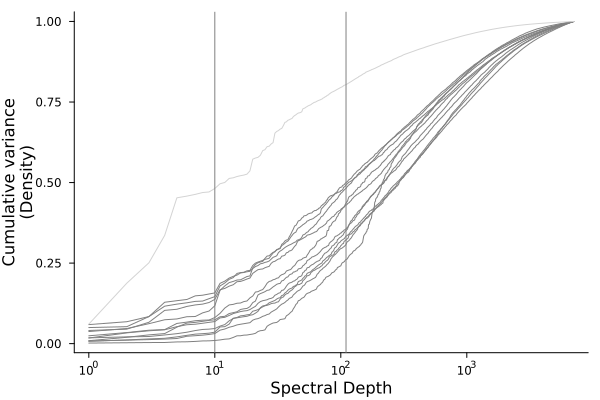

In [55]:
plot(ylabel="Cumulative variance\n(Density)", xlabel="Spectral Depth", tickdirection=:out)
plot!(pltmtx, xscale=:log10,xticks=[10^i for i in 0:4], c=:grey)
# plot!(scaledcumsum(explainedvariance(bbusv.S)), c=:black)
plot!(scaledcumsum(vec(var(SCs, dims=1))), c=:lightgrey)
vline!([10, 110], c=:grey)

In [22]:
scaledcumsum(vec(var(SCs, dims=1)))[12]

0.5002186182967208

In [23]:
sum(explainedvariance(bbusv.S)[1:12])

0.7947981735061413

In [24]:
sum(explainedvariance(bbusv.S)[111:7047])

0.0747591293277744

In [25]:
1 - scaledcumsum(vec(var(SCs, dims=1)))[110]

0.19581055803432545

In [26]:
pltmtx

7047×11 Matrix{Union{Missing, Float64}}:
 0.0176135  0.00740093  0.0179301  …  0.0243815  0.0092195  0.00175884
 0.033432   0.0114011   0.0210348     0.0344126  0.0197034  0.00279837
 0.0398971  0.0147003   0.0221428     0.0416595  0.0271963  0.00341645
 0.0430608  0.0165873   0.0269327     0.043605   0.0312372  0.00358492
 0.0527071  0.0210125   0.0309797     0.0627297  0.0512574  0.00533358
 0.0586834  0.0257418   0.0354506  …  0.0668319  0.0638329  0.00577017
 0.0603112  0.0294997   0.0406668     0.0711843  0.0660457  0.00693463
 0.063287   0.030962    0.0440251     0.0727718  0.0692741  0.00841567
 0.0661192  0.0325281   0.0450349     0.0733576  0.0721696  0.00869917
 0.0685723  0.0357017   0.0469456     0.0810187  0.074063   0.00985138
 ⋮                                 ⋱                        ⋮
 0.999936   0.999944    0.999936      0.999967   0.999919   0.999955
 0.999946   0.999955    0.999937      0.99997    0.999923   0.999958
 0.999951   0.999966    0.999942   …  0.999978   

In [27]:
minimum(mapslices(x -> findfirst(>(.5), x), pltmtx, dims=1))

111

In [28]:
sum(var(csbusv.U, dims=1) / var(bbmtx))

0.5100088605735644

In [29]:
maximum(permutedims(pltdf, :variable)[:, :SC_12])

0.1940347445994874

In [30]:
minimum(permutedims(pltdf, :variable)[:, :SC_12])

0.0137923325319575

In [31]:
mean(permutedims(pltdf, :variable)[:, :SC_10])

0.08234387861599785

In [32]:
extrema(1 .- permutedims(pltdf, :variable)[:, :SC_110])

(0.5004029783433575, 0.7388743971651476)

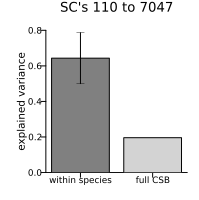

In [46]:
speciesvar_median = median(1 .- permutedims(pltdf, :variable)[:, :SC_110])
speciesvar_extrema = speciesvar_median .- [extrema(1 .- permutedims(pltdf, :variable)[:, :SC_110])...]

plot(
    title="SC's 110 to 7047",
    titlefontsize=9,
    ylabel="explained variance",
    ylabelfontsize=7,
    size=(200, 200),
    xtick=(1:2,["within species", "full CSB"]),
    tickfontsize=6,
    ylims=(0,.8),
)
bar!([1], [speciesvar_median], yerror=speciesvar_extrema, c=:grey)
bar!([2], [1 - scaledcumsum(vec(var(SCs, dims=1)))[110]], c=:lightgrey)

In [40]:
savefig(joinpath(pdir, "explainedvar_SC111_7047.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/explainedvar/explainedvar_SC111_7047.pdf"

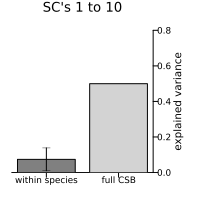

In [57]:
speciesvar_median = median(permutedims(pltdf, :variable)[:, :SC_10])
speciesvar_extrema = speciesvar_median .- [extrema(permutedims(pltdf, :variable)[:, :SC_10])...]

plot(
    title="SC's 1 to 10",
    titlefontsize=9,
    ylabel="explained variance",
    ylabelfontsize=7,
    size=(200, 200),
    xtick=(1:2,["within species", "full CSB"]),
    tickfontsize=6,
    ylims=(0,.8),
    ymirror=true,
)
bar!([1], [speciesvar_median], yerror=speciesvar_extrema, c=:grey)
bar!([2], [1 - scaledcumsum(vec(var(SCs, dims=1)))[12]], c=:lightgrey)

In [49]:
savefig(joinpath(pdir, "explainedvar_SC1_12.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/explainedvar/explainedvar_SC1_12.pdf"

In [60]:
sum(explainedvariance(bbusv.S)[110:end])

0.07512593812393017

In [61]:
sum(explainedvariance(bbusv.S)[1:10])

0.7809874897893229